In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import seaborn as sns
import importlib
import util
from util import *

# Content:
[1. Data Preprocessing](##Data-Preprocessing)
- [1.1 Convert txt files into CSV files](###Data-format-conversion)

[2. Data Description](##Data-Description)

- [2.1 Features in 'Ratings' dataset](###Features-in-'Ratings'-dataset)

- [2.2 Features in 'Users' dataset](###Features-in-'Users'-dataset)

- [2.3 Features in 'Breweries' dataset](###Features-in-'Breweries'-dataset)

- [2.4 Beer Styles](###Beer-Styles)

[3. Mathematical Details for Proposed Methods](##Mathematical-Details)

- [3.1 K-means](###K-means)

[4. Graph Network Modeling](##Graph-Network-Modeling)

## Data Preprocessing

### Data format conversion

In [2]:
# convert txt files into csv files
def txt_to_csv(filepath, output_file_name):
    print("opening....")
    with open(filepath) as f:
        txt = f.read()
    print("spliting....")
    lis_rating = txt.split('\n\n')
    print("formating....")
    data_list_dict = []
    for item in lis_rating:
        try:
            p = {ii.split(": ")[0]: ii.split(": ")[1] for ii in item.split('\n')}
        except:
            print(item)
            continue
        data_list_dict.append(p)
    print("dataframe....")
    df = pd.DataFrame(data_list_dict)
    print("to csv file.....")
    df.to_csv(output_file_name, sep=',', encoding='utf-8')

    return df

In [3]:
# read path
fp1 = "./BeerAdvocate/reviews.txt"
fp2 = "./matched_beer_data/ratings_ba.txt"
fp3 = "./matched_beer_data/ratings_rb.txt"
fp4 = "./matched_beer_data/ratings_with_text_ba.txt"
fp5 = "./matched_beer_data/ratings_with_text_rb.txt"
fp6 = "./RateBeer/ratings.txt"
fp7 = "./RateBeer/reviews.txt"

In [4]:
# write path
ofn1 = "reviews_ba.csv"
ofn2 = "m_ratings_ba.csv"
ofn3 = "m_reviews_rb.csv"
ofn4 = "m_ratings_text_ba.csv"
ofn5 = "m_ratings_text_rb.csv"
ofn6 = "ratings_rb.csv"
ofn7 = "reviews_rb.csv"

In [5]:
# df1 = txt_to_csv(fp1, ofn1)
# df2 = txt_to_csv(fp2, ofn2)
# df3 = txt_to_csv(fp3, ofn3)
# df4 = txt_to_csv(fp4, ofn4)
# df5 = txt_to_csv(fp5, ofn5)
# df6 = txt_to_csv(fp6, ofn6)
# df7 = txt_to_csv(fp7, ofn7)

We found the data size is too big too handle during our conversion step. Therefore we plan to use matched data from two websites in the following step.

## Data Description

In [6]:
# load the data:
beers = pd.read_csv('data/m_beers.csv')
ratings = pd.read_csv('data/m_ratings.csv')
users = pd.read_csv('data/m_users_approx.csv')
breweries = pd.read_csv('data/m_breweries.csv')

<ipython-input-6-f680b95e3c9a>:2: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers = pd.read_csv('data/m_beers.csv')
<ipython-input-6-f680b95e3c9a>:3: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv('data/m_ratings.csv')


In [7]:
#  check nan element-wise values:
print('nans in ratings:', sum(ratings.isna().any(axis=1)))
print('nans in users:', sum(users.isna().any(axis=1)))
print('nans in beers:', sum(beers.isna().any(axis=1)))
print('nans in breweries:', sum(breweries.isna().any(axis=1)))

nans in ratings: 4026
nans in users: 0
nans in beers: 45043
nans in breweries: 0


We will deal with these nan values later.

In [8]:
# ---------------can be found in util.py---------------

def split_matched_data(data):
    """split the data for two websites"""
    data_rb = data.filter(like='rb', axis=1)
    data_ba = data.filter(like='ba', axis=1)
    data_rb.columns = data_rb.iloc[0]
    data_rb = data_rb.iloc[1:].reset_index(drop=True)
    data_ba.columns = data_ba.iloc[0]
    data_ba = data_ba.iloc[1:].reset_index(drop=True)
    return data_rb, data_ba

In [9]:
beers_rb, beers_ba = split_matched_data(beers)
users_rb, users_ba = split_matched_data(users)
ratings_rb, ratings_ba = split_matched_data(ratings)
breweries_rb, breweries_ba = split_matched_data(breweries)

### Features in 'Ratings' dataset

In [10]:
# check the nan values in rating_ba (rating_rb doesn't contain nan value)
ratings_ba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21964 entries, 0 to 21963
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   abv           21964 non-null  object
 1   appearance    19295 non-null  object
 2   aroma         19295 non-null  object
 3   beer_id       21964 non-null  object
 4   beer_name     21964 non-null  object
 5   brewery_id    21964 non-null  object
 6   brewery_name  21964 non-null  object
 7   date          21964 non-null  object
 8   overall       19295 non-null  object
 9   palate        19295 non-null  object
 10  rating        21964 non-null  object
 11  review        21964 non-null  object
 12  style         21964 non-null  object
 13  taste         19295 non-null  object
 14  text          18278 non-null  object
 15  user_id       21964 non-null  object
 16  user_name     21964 non-null  object
dtypes: object(17)
memory usage: 2.8+ MB


- The nan values are all from important features (`overall`, `appearance`, `aroma`, `palate`, etc.) in this data set. So we decided to drop items with nan.

In [11]:
ratings_ba.dropna(inplace=True)
ratings_ba.reset_index(drop=True)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,review,style,taste,text,user_id,user_name
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,4.8,True,Quadrupel (Quad),5.0,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel
1,5.0,3.5,3.5,57911,Cantillon Tyrnilambic Baie D’Argousier Lambic,388,Brasserie Cantillon,1344074400,4.0,4.0,3.85,True,Lambic - Fruit,4.0,"Bottle @ One Pint Pub, Helsinki. 2006 vintage....",tiong.608427,tiong
2,5.0,4.0,3.5,57913,Cantillon Pikkulinnun Viskilambic,388,Brasserie Cantillon,1344074400,4.0,4.0,3.68,True,Lambic - Unblended,3.5,"Originally rated on 16.11.2009, draught @ Pikk...",tiong.608427,tiong
3,6.0,4.0,4.0,81125,Drie Fonteinen Oude Geuze - Armand & Tommy,2216,Brouwerij 3 Fonteinen,1346234400,4.0,4.0,4.0,True,Gueuze,4.0,"750ml bottle, originally rated on 18.8.2012.Bo...",tiong.608427,tiong
4,5.0,4.0,4.0,67932,Cantillon Olutravintola Pikkulintu,388,Brasserie Cantillon,1344074400,4.0,4.5,4.05,True,Lambic - Unblended,4.0,"375ml bottle @ Pikkulintu, Helsinki. Originall...",tiong.608427,tiong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17933,6.1,4.75,4.5,48720,Native Amber Red IPA,19456,COOP Ale Works,1435917600,4.75,3.75,4.59,True,American Amber / Red Ale,4.75,Deep Amber with nice head retention and lacing...,deezee83.998987,DeeZee83
17934,6.5,4.0,3.5,22048,Vlasbier,634,Brouwerij Van Eecke N.V.,1230548400,1.5,2.0,2.58,True,Belgian Pale Ale,2.5,"This smelled sweet and floral, but the mouthfe...",idler.183543,Idler
17935,9.0,3.5,4.0,4718,Vapeur Cochonne,841,Brasserie à Vapeur,1323860400,4.0,3.5,3.92,True,Belgian Strong Dark Ale,4.0,75cl bottle from Belgian Beer Station. Bottle ...,thebeerwatcher.630107,TheBeerWatcher
17936,8.5,4.5,3.5,28030,Valeir Divers,3463,Brouwerij Contreras,1323946800,4.0,4.0,3.91,True,Tripel,4.0,Valeir Divers 33cl bottle from www.belgianbeer...,thebeerwatcher.630107,TheBeerWatcher


In [12]:
# The type of all the features is 'object'. Convert some of them to float.
convert_features=['abv', 'appearance', 'aroma', 'overall', 'palate', 'rating', 'taste']
ratings_rb[convert_features] = ratings_rb[convert_features].apply(pd.to_numeric, errors = 'coerce')
ratings_ba[convert_features] = ratings_ba[convert_features].apply(pd.to_numeric, errors = 'coerce')

In [13]:
ratings_ba[ratings_ba['abv']>=9]

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,review,style,taste,text,user_id,user_name
0,11.3,4.50,4.50,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.00,4.50,4.80,True,Quadrupel (Quad),5.00,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel
9,12.0,4.00,4.00,76421,Mornin' Delight,23222,Toppling Goliath Brewing Company,1456830000,4.00,4.00,4.00,True,American Double / Imperial Stout,4.00,Draft. Pours oily black with a creamy brown he...,leighton.343447,leighton
10,9.1,4.75,4.75,237682,Beavertown / Boneyard Bloody Notorious,30471,Beavertown Brewery,1467021600,4.75,4.75,4.75,True,American Double / Imperial IPA,4.75,Keg at the brewery. Pours just slightly hazy y...,leighton.343447,leighton
12,10.0,4.25,4.25,175027,Power Of The Voodoo,30471,Beavertown Brewery,1436436000,4.50,4.25,4.40,True,American Double / Imperial IPA,4.50,Can at home in London - sourced from Ales by M...,leighton.343447,leighton
54,9.2,5.00,4.50,250260,Kermis Upgraded 10k,40854,Brouwerij Kwartje,1475056800,4.50,4.75,4.56,True,Russian Imperial Stout,4.50,Draft at Kaapse Borefts After Festival 2016. B...,kermis.705828,kermis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21916,9.1,5.00,4.50,155232,Cool Beans Imperial Coffee Porter,29402,Third Street Brewhouse,1423220400,4.50,4.25,4.51,True,American Porter,4.50,Great coffee aroma. Really nice beer.,jpallinder.939910,jpallinder
21939,11.3,4.00,4.50,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1091700000,4.50,4.50,4.47,True,Quadrupel (Quad),4.50,This bottle had a best by date of 14Jan08. Pou...,imblane.5525,imblane
21942,11.5,4.00,3.50,7588,Sisyphus,458,Real Ale Brewing Company,1125655200,3.00,3.50,3.43,True,American Barleywine,3.50,"Pours a dull, hazy dark orange, virtually no h...",assurbanipaul.1754,assurbanipaul
21958,9.0,3.50,4.00,4718,Vapeur Cochonne,841,Brasserie à Vapeur,1323860400,4.00,3.50,3.92,True,Belgian Strong Dark Ale,4.00,75cl bottle from Belgian Beer Station. Bottle ...,thebeerwatcher.630107,TheBeerWatcher


In [14]:
ratings_rb[convert_features].describe()

,abv,appearance,aroma,overall,palate,rating,taste
count,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000
mean,6.800216,3.685986,6.960344,14.401657,3.535057,3.558824,7.005190
std,2.096192,0.677436,1.355669,2.677514,0.733544,0.585348,1.384695
min,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000
25%,5.200000,3.000000,6.000000,13.000000,3.000000,3.300000,6.000000
50%,6.400000,4.000000,7.000000,15.000000,4.000000,3.600000,7.000000
75%,8.000000,4.000000,8.000000,16.000000,4.000000,4.000000,8.000000
max,39.000000,5.000000,10.000000,20.000000,5.000000,5.000000,10.000000


In [15]:
ratings_ba[convert_features].describe()

,abv,appearance,aroma,overall,palate,rating,taste
count,17938.000000,17938.000000,17938.000000,17938.000000,17938.000000,17938.000000,17938.000000
mean,6.804901,3.794222,3.705277,3.734028,3.687061,3.719170,3.714893
std,2.104107,0.566788,0.607502,0.624533,0.626139,0.556847,0.632683
min,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.200000,3.500000,3.500000,3.500000,3.500000,3.450000,3.500000
50%,6.400000,4.000000,3.750000,4.000000,3.750000,3.780000,3.750000
75%,8.000000,4.000000,4.000000,4.000000,4.000000,4.080000,4.000000
max,39.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [16]:
# min_max_scaler = MinMaxScaler()
# ratings_rb[convert_features] = pd.DataFrame(min_max_scaler.fit_transform(ratings_rb[convert_features]), columns=convert_features)
# ratings_ba[convert_features] = pd.DataFrame(min_max_scaler.fit_transform(ratings_ba[convert_features]), columns=convert_features)

ratings_rb_with_convert_features = ratings_rb[convert_features]
ratings_ba_with_convert_features = ratings_ba[convert_features]
ratings_rb[convert_features] = (ratings_rb_with_convert_features - ratings_rb_with_convert_features.min()) / (ratings_rb_with_convert_features.max() - ratings_rb_with_convert_features.min())
ratings_ba[convert_features] = (ratings_ba_with_convert_features - ratings_ba_with_convert_features.min()) / (ratings_ba_with_convert_features.max() - ratings_ba_with_convert_features.min())

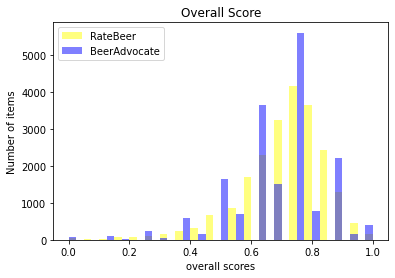

In [17]:
# plot the histgram of the overall score from two websites respectively
plt.hist(ratings_rb['overall'], bins=40, alpha = 0.5, label = 'RateBeer', color='yellow')
plt.hist(ratings_ba['overall'], bins=40, alpha = 0.5, label = 'BeerAdvocate', color='blue')

plt.xlabel('overall scores')
plt.ylabel('Number of items')
plt.title('Overall Score')
plt.legend()

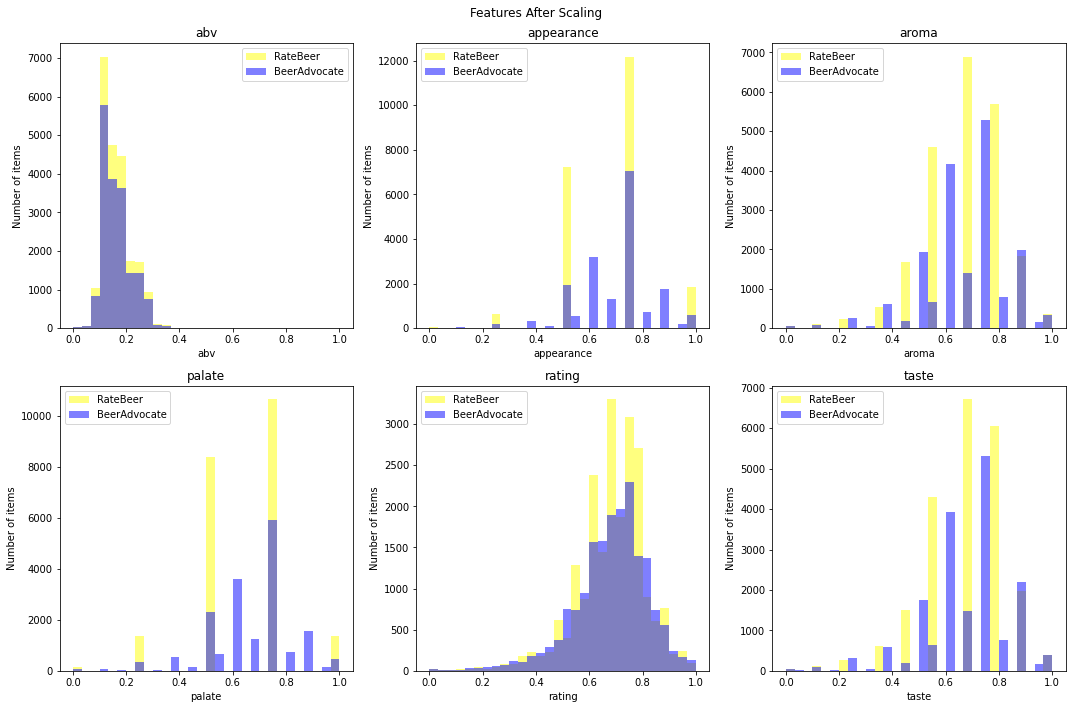

In [18]:
# plot the histgram of other features from the two websites
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

i = 0
for feature in convert_features:
    if feature != 'overall':
        ax = axs[i//cols][i%cols]
        ax.hist(ratings_rb[feature], bins=30, alpha = 0.5, label = 'RateBeer', color='yellow')
        ax.hist(ratings_ba[feature], bins=30, alpha = 0.5, label = 'BeerAdvocate', color='blue')
        ax.set_xlabel(feature)
        ax.set_ylabel('Number of items')
        ax.set_title(feature)
        ax.legend()
        i += 1
        
plt.suptitle('Features After Scaling')
fig.tight_layout()
plt.show()

We found the distribution between 'appearance' and 'palate'; 'taste' and 'aroma' are really similar. So then we'll try to explore the connection across the features.

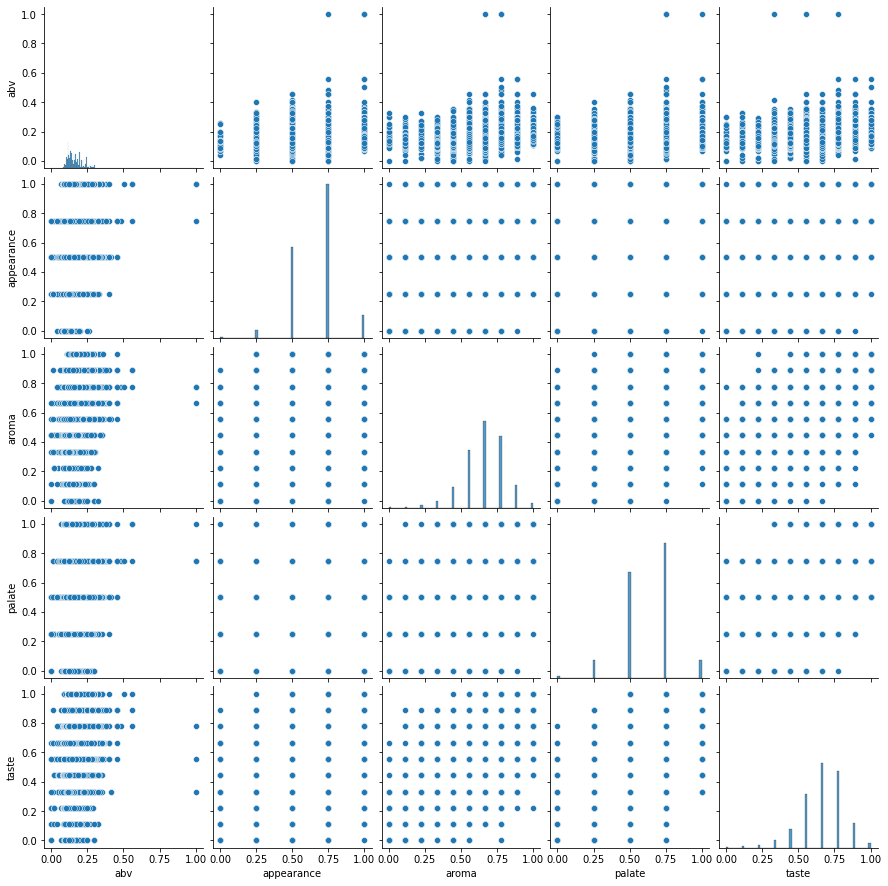

In [19]:
detailed_features = ['abv', 'appearance', 'aroma', 'palate', 'taste']
sns.pairplot(ratings_rb[detailed_features])
plt.show()

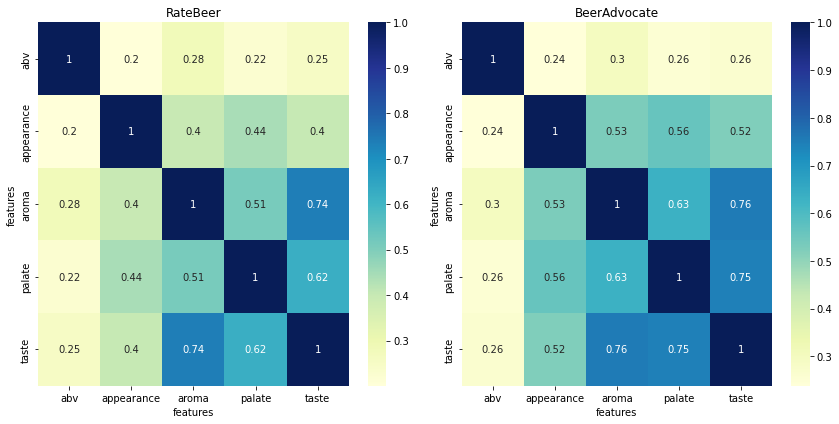

In [20]:
# heat map for different features:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(ratings_rb[detailed_features].corr(), ax = axs[0], annot=True, cmap='YlGnBu', cbar=True)
sns.heatmap(ratings_ba[detailed_features].corr(), ax = axs[1], annot=True, cmap='YlGnBu', cbar=True)
axs[0].set_title('RateBeer')
axs[0].set_xlabel('features')
axs[0].set_ylabel('features')

axs[1].set_title('BeerAdvocate')
axs[1].set_xlabel('features')
axs[1].set_ylabel('features')
fig.tight_layout()
plt.show()


There are some strong linear connections between features. These can be discussed in details in our further work.

In [21]:
# try regression model on features and overall ratings
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

model = RidgeCV(alphas=[0.01, 0.05, 0.1])
X_train, X_test, y_train, y_test = train_test_split(
    ratings_ba[detailed_features], ratings_ba["overall"], test_size=0.2, random_state=42
)

In [22]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7657120104463955

In [23]:
# check the contribution of each coefficient
sorted_coef_pairs = sorted(
    zip(model.coef_, detailed_features), key=lambda x: abs(x[0]), reverse=True
)
sorted_coefs = [pair[0] for pair in sorted_coef_pairs]
sorted_features = [pair[1] for pair in sorted_coef_pairs]

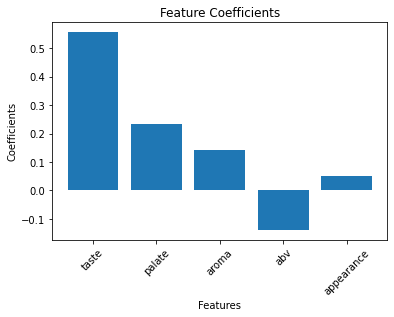

In [24]:
plt.figure(figsize=(6, 4))  # You can adjust the figure size as needed
plt.bar(sorted_features, sorted_coefs)

# Adding labels and title
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Feature Coefficients')
plt.xticks(rotation=45)  # Rotates feature names for better readability

plt.show()

## Features in 'Users' dataset

In [25]:
users_loc_ba = users_ba.groupby('location').size()
users_loc_rb = users_rb.groupby('location').size()

In [26]:
False in users_loc_ba == users_loc_rb

False

Notice that 'location' counts states for US users and countries only for other users, so break the data down into US users and non-US users. Since the dataset is matched, we only need to discuss the loaction distribution of one website.

In [27]:
# splite the us and non-us users
users_loc_ba_US = users_loc_ba[users_loc_ba.index.str.contains('United States')]
users_loc_ba_nonUS = users_loc_ba[~users_loc_ba.index.str.contains('United States')]

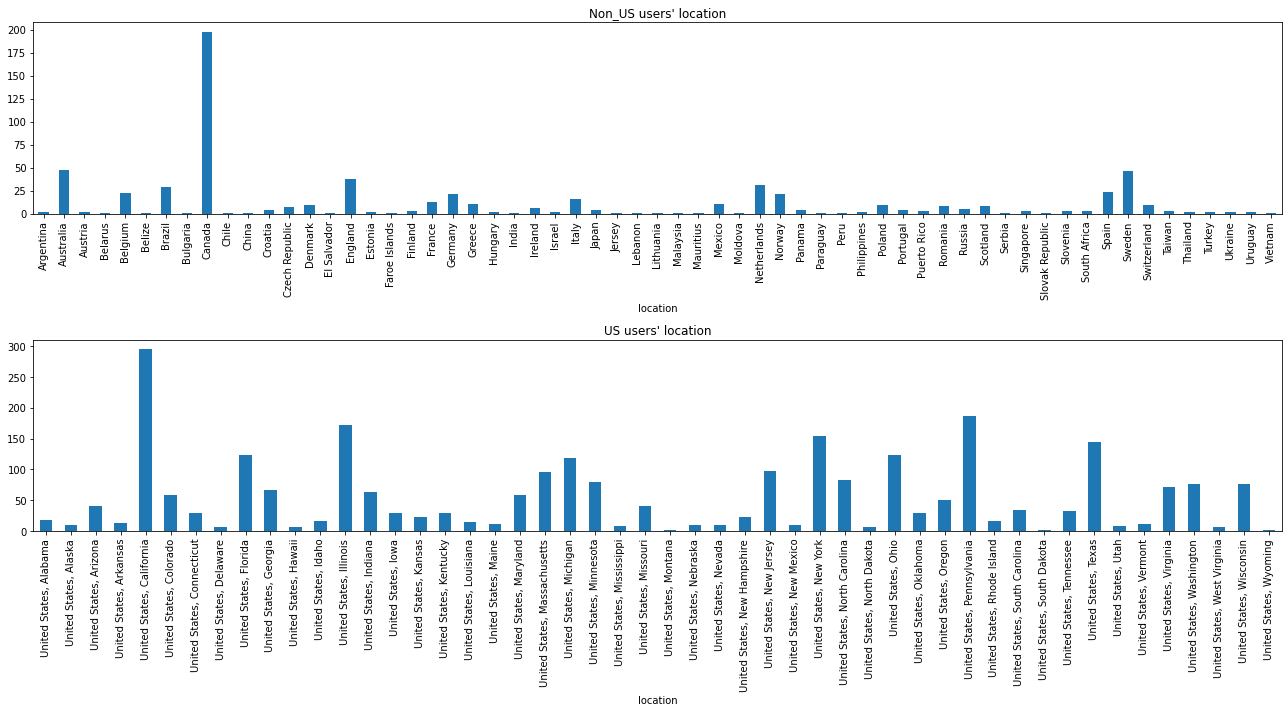

In [28]:
fig, axs = plt.subplots(2, 1, figsize = (18, 10))
users_loc_ba_nonUS.plot(kind = 'bar', ax = axs[0])
users_loc_ba_US.plot(kind = 'bar', ax = axs[1])

axs[0].set_title("Non_US users' location")
axs[1].set_title("US users' location")

fig.tight_layout()
plt.show()

There are far more users in the United States than in other countries, which will be taken into account in our subsequent work.

### Features in 'Breweries' dataset

In [29]:
breweries_loc_rb = breweries_rb.groupby('location').size()
breweries_loc_ba = breweries_ba.groupby('location').size()

In [30]:
False in breweries_loc_rb == breweries_loc_ba

False

In [31]:
# splite the us and non_us locations
breweries_loc_ba_US = breweries_loc_ba[
    breweries_loc_ba.index.str.contains("United States", "U.S.")
    | breweries_loc_ba.index.str.contains("U.S.")
]
breweries_loc_ba_nonUS = breweries_loc_ba[
    ~(
        breweries_loc_ba.index.str.contains("United States", "U.S.")
        | breweries_loc_ba.index.str.contains("U.S.")
    )
]

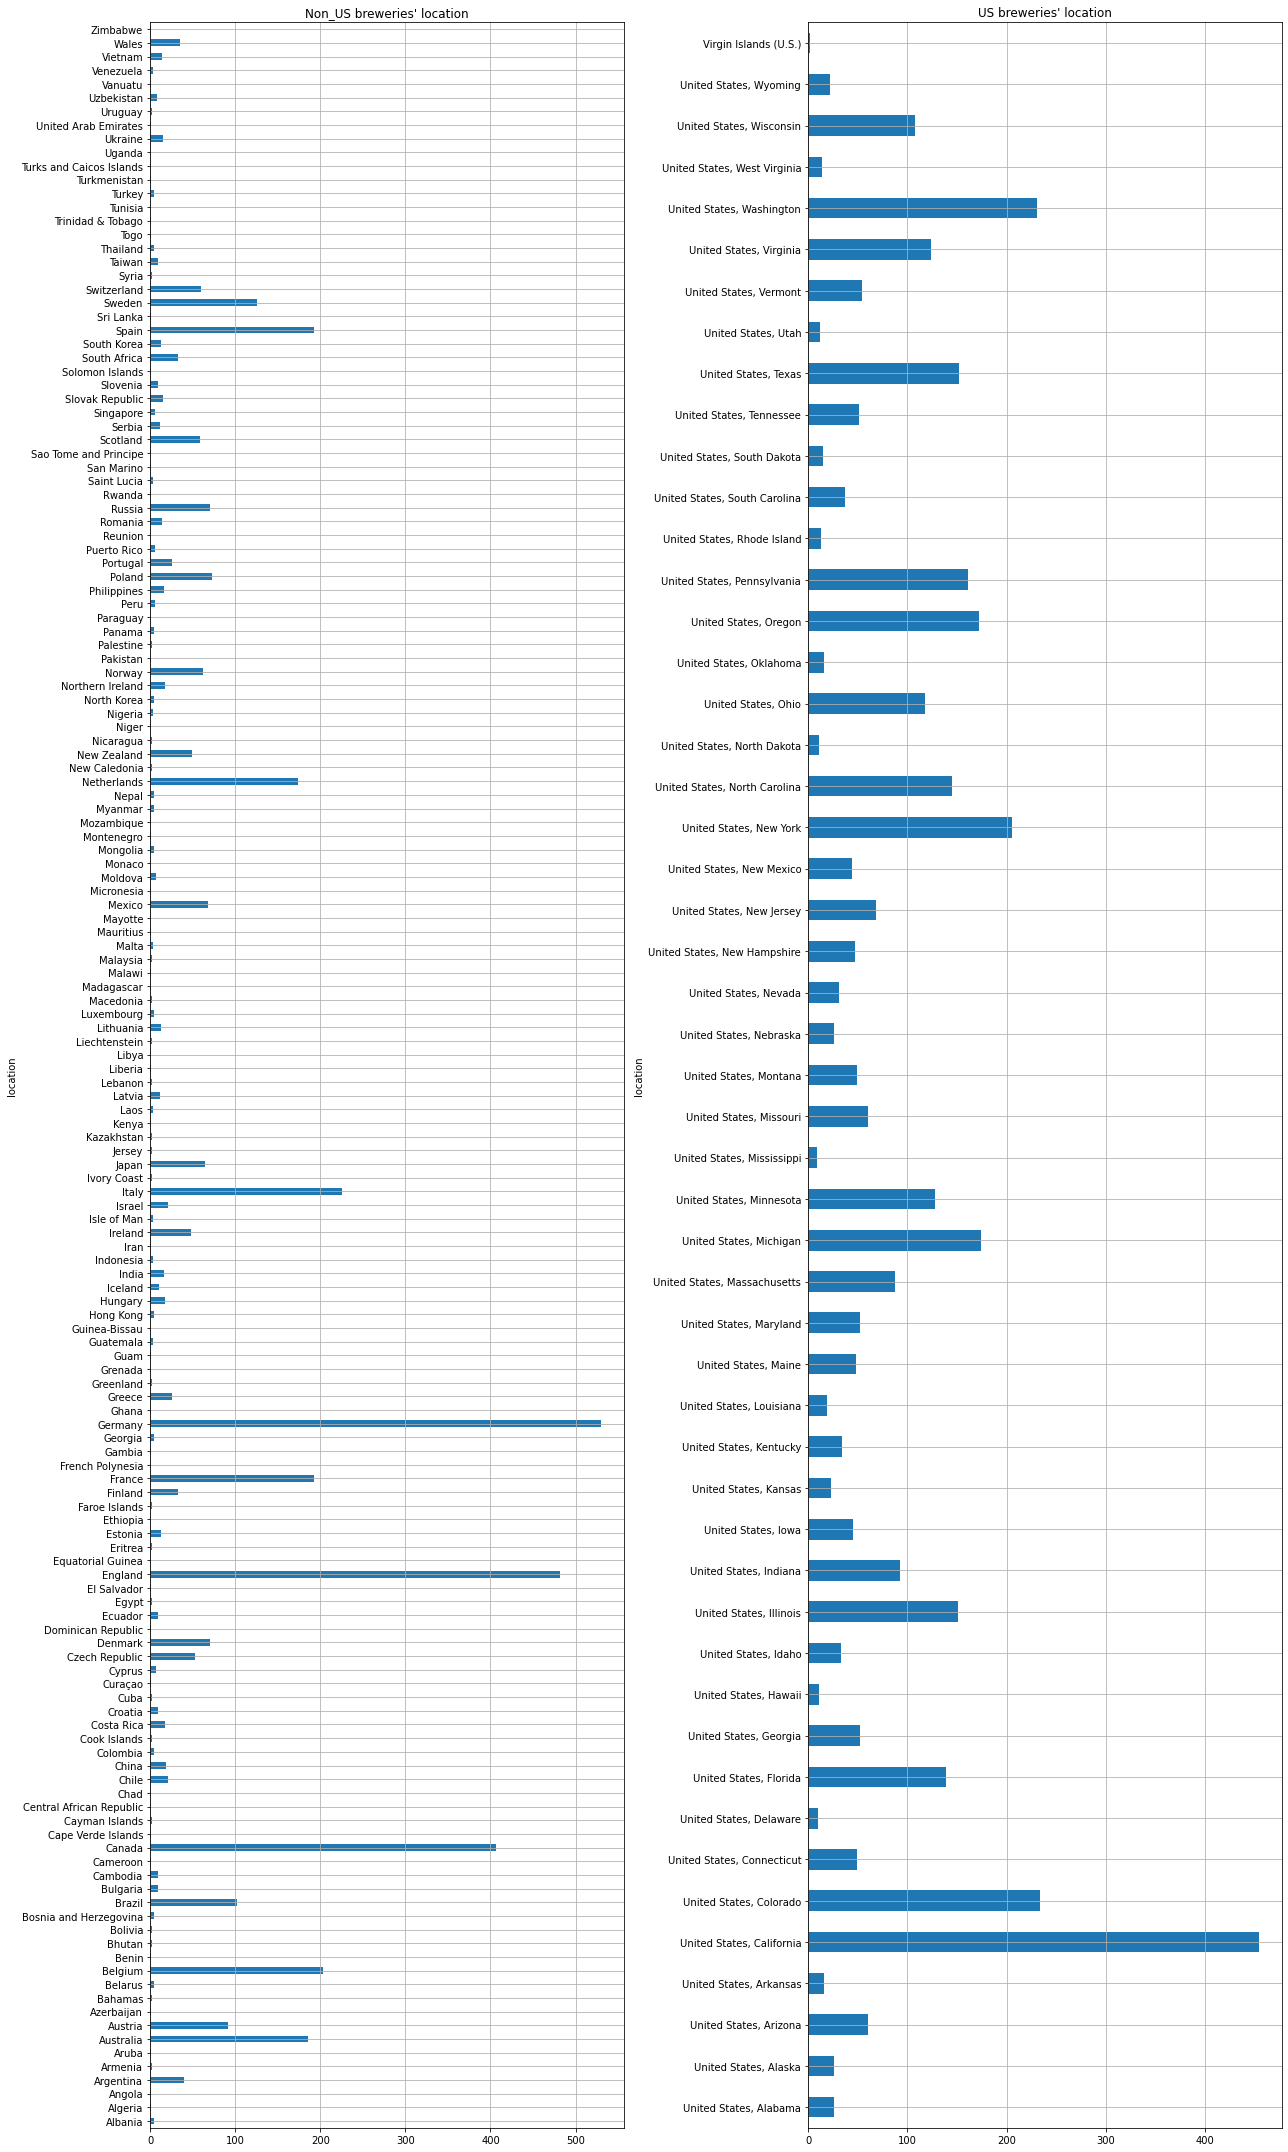

In [32]:
fig, axs = plt.subplots(1, 2, figsize = (18, 30))
breweries_loc_ba_nonUS.plot(kind = 'barh', ax = axs[0], grid=True)
breweries_loc_ba_US.plot(kind = 'barh', ax = axs[1], grid=True)

axs[0].set_title("Non_US breweries' location")
axs[1].set_title("US breweries' location")

fig.tight_layout()
plt.show()

### Beer Styles

In [55]:
style_counts = beers_ba['style'].value_counts()

In [56]:
style_percentages = style_counts / style_counts.sum() * 100
style_percentages

style
American IPA                      12.149430
American Pale Ale (APA)            6.770377
Saison / Farmhouse Ale             5.887379
American Double / Imperial IPA     4.993427
American Wild Ale                  3.422436
                                    ...    
Kvass                              0.035057
Japanese Rice Lager                0.030675
Happoshu                           0.017528
Faro                               0.015337
Black & Tan                        0.013146
Name: count, Length: 104, dtype: float64

In [35]:
beers_style = list(set(beers_ba['style']))

In [41]:
# get beers style description by crawling
import requests
from bs4 import BeautifulSoup
import csv

# The base URL of the beer style guidelines
url = 'https://www.brewersassociation.org/edu/brewers-association-beer-style-guidelines/'
# CSV file where the data will be saved
csv_file = '/data/beer_styles_descriptions.csv'
# Define headers to simulate a browser visit
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:88.0) Gecko/20100101 Firefox/88.0'
}

In [49]:
# Send a GET request to the website
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the content of the request with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the section containing the beer styles
    beer_styles_section = soup.find('section', id='beer-styles')
    
    # Find all individual beer style entries within that section
    beer_styles = beer_styles_section.find_all('div', class_='beer-style')
    
    # Prepare a list to hold all the scraped data
    beer_style_data = []
    
    # Loop over each beer style and extract the data
    for beer_style in beer_styles:
        # Find the name of the beer style
        style_name = beer_style.find('li').text.strip()
        
        # Find all the characteristics of the beer style
        characteristics = beer_style.find_all('li')[1:]  # Skip the first li as it's the name
        
        # Prepare a dictionary to hold the data for this beer style
        style_data = {
            'Style Name': style_name,
            'Characteristics': ' | '.join([char.text.strip() for char in characteristics])
        }
        
        # Add the dictionary to our list of all data
        beer_style_data.append(style_data)
    
    # Specify the filename to write to
    csv_filename = './data/beer_styles.csv'
    
    # Writing the data to a CSV file
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['Style Name', 'Characteristics'])
        writer.writeheader()
        for data in beer_style_data:
            writer.writerow(data)
    
    print(f"Data scraped and saved to {csv_filename}")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

Data scraped and saved to ./data/beer_styles.csv


In [52]:
# Create a DataFrame with the example text as a column
df = pd.read_csv('./data/beer_styles.csv')
df.columns = ['style', 'characteristics']
# Split the 'Characteristics' column into multiple columns at the '|'
# First, separate the characteristics into individual items
df_characteristics = df['characteristics'].str.split(' \| ', expand=True)

# Create a new DataFrame to hold the processed columns
df_split = pd.DataFrame()
df_split['style_name'] = df['style']

# Iterate over the separated items to further split and get a key:value format
for i in df_characteristics.columns:
    # Split each item into a key and value at the first ':'
    df_split_temp = df_characteristics[i].str.split(': ', n=1, expand=True)
    # Assign the key to the column name and the value to the cell, if split was successful
    if len(df_split_temp.columns) > 1:
        df_split[df_split_temp[0].iloc[0]] = df_split_temp[1]

df_split.head()

,style_name,Color,Clarity,Perceived Malt Aroma & Flavor,Perceived Hop Aroma & Flavor,Perceived Bitterness,Fermentation Characteristics,Body,"Additional notes:\nWhen using these guidelines as the basis for evaluating entries at competitions, competition organizers may choose to create subcategories which reflect English and American hop character."
0,Ordinary Bitter,Gold to copper-colored,Chill haze is allowable at cold temperatures,Low to medium residual malt sweetness should b...,Very low to medium-low,Medium,Mild carbonation traditionally characterizes d...,Low to medium,None
1,Special Bitter or Best Bitter,Deep gold to deep copper,Chill haze is acceptable at low temperatures,Medium residual malt sweetness should be present,Very low to medium at the brewer’s discretion,Medium and not harsh,Low carbonation traditionally characterizes dr...,Medium,None
2,Extra Special Bitter,Amber to deep copper,Chill haze is acceptable at low temperatures,Medium to medium-high,Medium to medium-high,Medium to medium-high,Low carbonation traditionally characterizes dr...,Medium,None
3,Scottish-Style Light Ale,Gold to light brown,Chill haze is acceptable at low temperatures,"Malty, caramel aroma may be present. A low to ...",Should not be present,Low,Yeast attributes such as diacetyl and sulfur a...,Low,None
4,Scottish-Style Heavy Ale,Amber to dark brown,Chill haze is acceptable at low temperatures,"Malty, caramel aroma is present. The style exh...",Should not be present,Perceptible but low,Yeast attributes such as diacetyl and sulfur a...,Medium with a soft chewy character,None


In [53]:
df_split[['style_name', 'Color', 'Clarity', 'Perceived Malt Aroma & Flavor', 
          'Perceived Hop Aroma & Flavor', 'Perceived Bitterness', 'Fermentation Characteristics', 'Body']].to_csv('./data/beer_styles.csv')

## Mathematical Details
### 1. K-means
K-means can be considered an optimization problem
$$
\begin{align*}
C^*=\mathrm{arg} \min\limits_{C} W(C)=
\mathrm{arg} \min\limits_{C}\sum_{l=1}^{k}\sum_{C(i)=l} d(x_i, m_j)
\end{align*}
$$
This is to solve the best clustering $C^*$ such that the sum of the distance between the data point and the centroids/clustroid of its cluster is minimized under the selected metric. $d(x_i, m_j)$ is the distance between $x_i$ and the centroid/centroid $m_j$ of cluster $C_j$.

Suppose we use the squared Euclidean distance $d(x_i, m_j) = ||x_i-m_l||^2$ . After initializing the cluster centroids $m_1, m_2, \cdots, m_k$, the algorithm is solved by two steps:

1. **Find the nearest cluster for each data point and assign them to the corresponding cluster**. 

   Find $C^*$ s.t.  $C^* = \mathrm{arg} \min\limits_{C}\sum\limits_{l=1}^{k}\sum\limits_{C(i)=l} ||x_i-m_l||^2$ for the given $m_1,m_2,... m_l$.

2. **Update the cluster centroid of each cluster.** 

   For current $C$, recompute $m_l=\frac{1}{|C_l|}\sum\limits_{C(i)=l}x_i$ for $l = 1, \cdots k$.	

Alternate these two steps until the stop criterion.